In [1]:
#!g1.1
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
import torch.nn as nn
from torch.optim import Adam

In [2]:
#!g1.1
import gensim.downloader as api

fasttext = api.load('glove-twitter-25')

In [3]:
#!g1.1
import re
import string
from collections import Counter


class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]

    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext):
        vectors = []

        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [4]:
#!g1.1
import pandas as pd


df = pd.read_csv('C:/Users/Alex/Desktop/Repos/Start_ML/Deep_learning/8_vectorizing_words/IMDB Dataset.csv')


In [5]:
#!g1.1
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
from torch.utils.data import Dataset

class IMDB(Dataset):

    def __init__(self, dataset, vocab):

        self.dataset = dataset
        self.vocab = vocab

        self.label2idx = {"positive": 0, "negative": 1}

    def __getitem__(self, idx):
        text = self.dataset["review"].loc[idx]
        label = self.label2idx[self.dataset["sentiment"].loc[idx]]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.dataset)


vocab = Vocabulary(df['review'].values, min_freq=5)

dataset = IMDB(df, vocab)


df_train, df_test = np.split(df, [45000], axis=0)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

train_dataset = IMDB(df_train, vocab)
test_dataset = IMDB(df_test, vocab)

In [7]:
#!g1.1
test_dataset[1]

(tensor([24933, 37898, 11859, 12274, 36878, 30708, 11859, 12274, 34276, 32351,
         11859, 12274,  5200, 36267, 32493, 39272, 14246, 37898,  7344, 39272,
         12815, 34276,  7344,  9847,  7344, 39272, 12274, 18888, 39272,   564,
         11859, 21852, 15064, 19300, 38321,  9650,  8946, 12815, 11240, 33503,
          7344,   144, 39272, 29669,   359, 37898, 11859, 33447,   521, 39272,
          2519,  6446, 39272, 39272, 39272, 29609,  7860, 12420, 12815, 19871,
          2456, 33645, 39272,  2457, 38321, 12815, 39272, 18888, 36706, 18605,
         35784, 12815,  5873, 16343, 21680, 26407, 35140, 12815, 26148, 39272,
         37973,  3087, 39272, 16412,  3764, 22872, 39272, 39272,  7798, 12420,
         33645, 29609, 38321, 28056, 25226, 33645, 19016,  3348, 28748, 39272,
         12420, 39272, 19688, 33645,  9903, 39272, 39272, 22008, 21680, 26407,
         22295,  4999, 38321, 39272, 34687, 20977, 37898, 39272,  2456, 12815,
         36267,   225, 25769, 26444, 29067, 23290, 3

In [8]:
train_dataset[0]

(tensor([ 9847,  7344, 12815, 32469,   994, 22711, 15304, 14790, 21165, 15781,
          3764, 39272, 12297, 31926, 39272,  6446, 39272, 16412, 11133, 39272,
          2456, 14246, 37898,  9394, 18707,   593, 30708, 39272, 39272, 39272,
         20787,  8775, 14790, 23844,  9650, 32351, 12297,  7798, 23513, 12341,
           564, 29427,  5968,  7344, 39272, 15538, 10378, 12420, 14870,  8946,
         12815,  6722, 39272, 30170, 39272, 14246, 37898, 26407, 11859,   198,
         19688, 12815, 36049,  4816,   797, 39272, 14246,   198, 12929, 13926,
          8192, 30708, 37771, 38321, 39272, 22192,   797, 39272, 23513, 37898,
         39272, 12420, 12815, 31983, 24001,  7344, 12815, 39272, 39272, 39272,
         37898, 21401, 12297,  2456, 14790, 37898, 12815, 20549,  7809, 38321,
         12815, 20443,  6009, 36431, 14140, 39272, 30164, 16143, 16139, 18605,
         26486, 39272,  5633, 34733, 20511,  7344, 12815, 11949, 35983,  7613,
         12815, 26408, 16385, 20603, 28350,   564, 2

In [9]:
#!g1.1
len(train_dataset), len(test_dataset)

(45000, 5000)

In [10]:
#!g1.1
from torch.nn.utils.rnn import pad_sequence

pad_idx = len(dataset.vocab.vocabulary)

def collate_fn(batch):
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])

    return texts, labels

In [11]:
#!g1.1
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [12]:
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels = 1,
                        out_channels = 32,  # Увеличено количество выходных каналов
                        kernel_size = (fs, embedding_dim)
                    ),
                    nn.BatchNorm2d(32),  # Добавлена Batch Normalization
                    nn.ReLU()
                )
                for fs in [2, 3, 4, 5]
            ]
        )

        self.fc = nn.Sequential(
            nn.Linear(4 * 32, 32),  # Добавлен дополнительный полносвязный слой
            nn.ReLU(),
            nn.Linear(32, 1),
        )

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [conv(x).squeeze(3) for conv in self.convs]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim = 1))

        return self.fc(x)


In [13]:
#!g1.1
model = TextCNN(vocab_size=len(dataset.vocab.vocabulary) + 1, embedding_dim=25, pad_idx=pad_idx)

In [14]:
#!g1.1
from tqdm import tqdm


def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(model, loader) -> float:
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y)

        loss.backward()

        optimizer.step()

    train_loss /= len(loader)
    train_accuracy /= len(loader)

    return train_loss, train_accuracy

In [15]:
#!g1.1
import torch


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y)

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

In [16]:
#!g1.1
import matplotlib.pyplot as plt
from IPython.display import clear_output

def to_cpu(data):
    if isinstance(data, list):
        return [to_cpu(item) for item in data]
    elif isinstance(data, torch.Tensor) and data.is_cuda:
        return data.cpu()
    else:
        return data

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):

    train_loss = to_cpu(train_loss)
    valid_loss = to_cpu(valid_loss)
    train_accuracy = to_cpu(train_accuracy)
    valid_accuracy = to_cpu(valid_accuracy)


    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [17]:
#!g1.1

def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        print(f'Эпоха: {epoch}')
        train_loss, train_accuracy = train(model, train_loader)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        print(valid_accuracy)
        if valid_accuracy>=0.871:
            break

In [18]:
#!g1.1
import torch.nn as nn
from torch.optim import Adam

In [19]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.BCEWithLogitsLoss()

cuda:0
NVIDIA GeForce RTX 3080


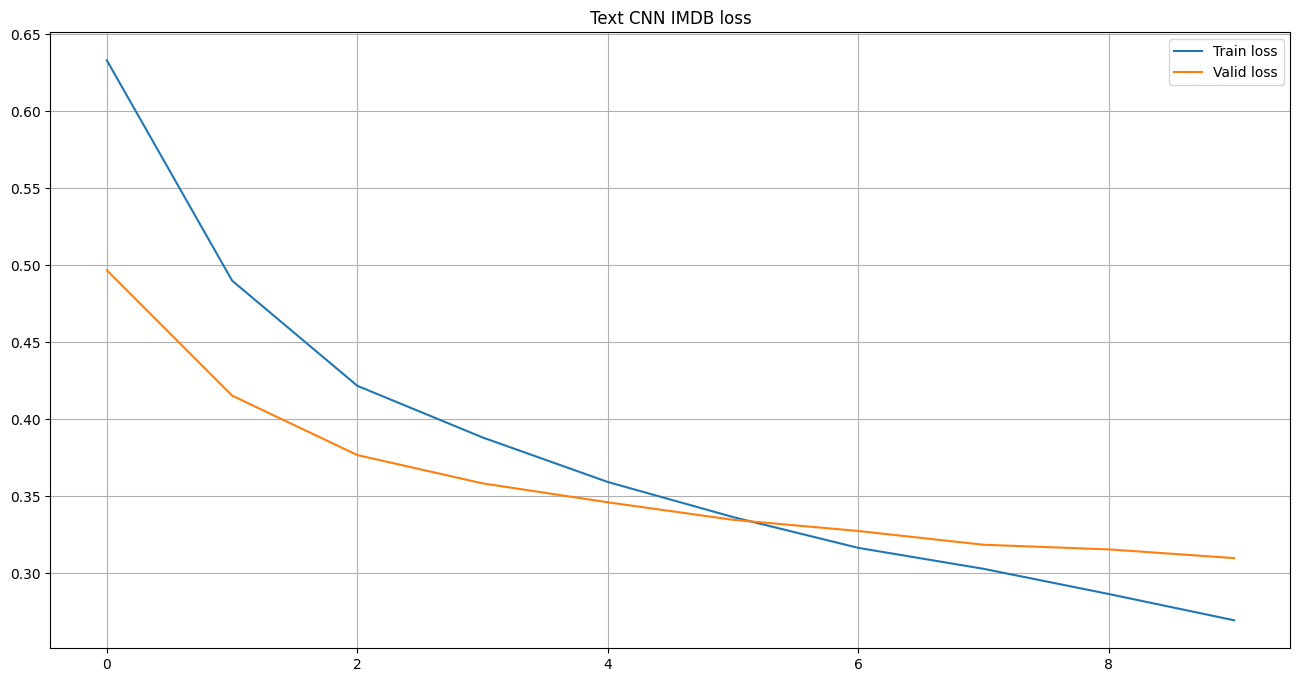

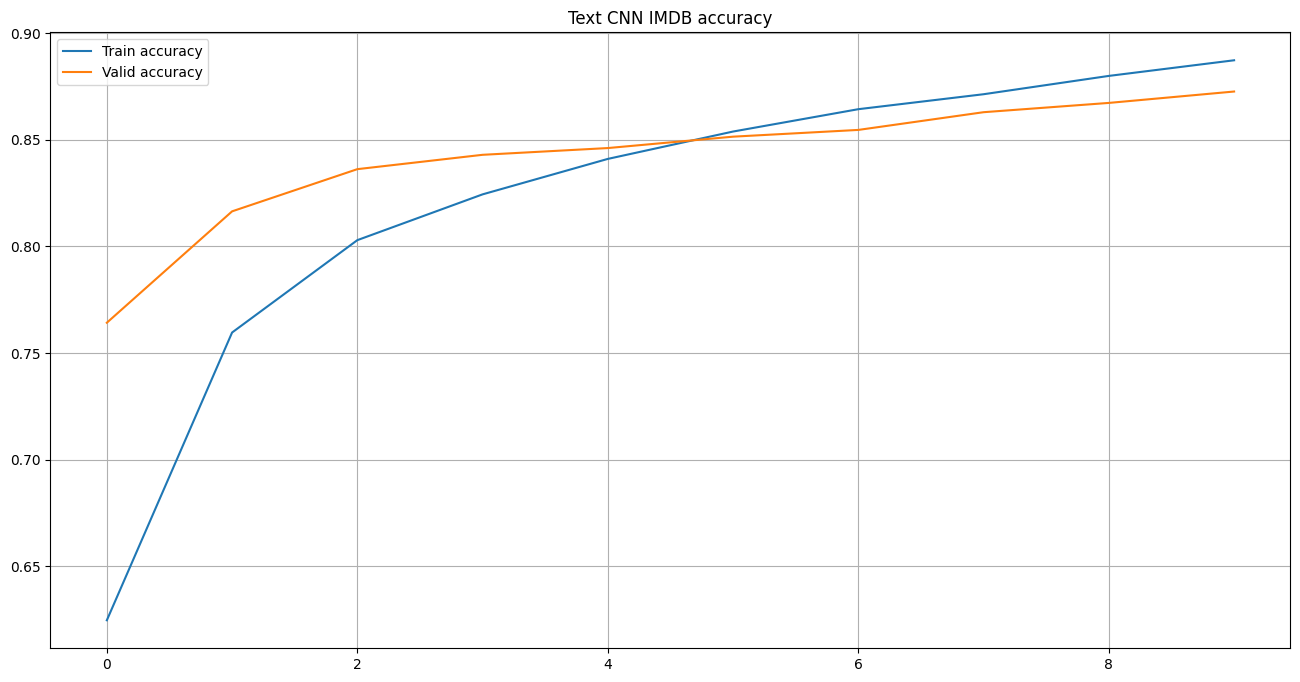

tensor(0.8726, device='cuda:0')


In [20]:
#!g1.1
model = model.to(device)

#optimizer = Adam(model.parameters(), lr=1e-3)
params = list(model.named_parameters())
optimizer = torch.optim.Adam([
    {'params': model.embedding.parameters(), 'weight_decay': 1e-5},
    {'params': [p for n, p in params if n != 'embedding.weight'], 'weight_decay': 0.0}
], lr=1e-3)



whole_train_valid_cycle(model, 15, 'Text CNN IMDB')

In [21]:
torch.save(model.state_dict(), 'model.pth')

In [22]:
def predict(model, tokenized_sentence):
    model.eval() # set the model to evaluation mode
    model.to('cpu')
    tokenized_sentence = tokenized_sentence.to('cpu') # move input to correct device
    output = model(tokenized_sentence) # forward pass
    prediction = torch.sigmoid(output) # apply sigmoid to get probabilities
        
    return (prediction > 0.5).int().squeeze()

preds = []

for i in range(len(test_dataset)): # use len(test_dataset) instead of 5000
    pred = predict(model, test_dataset[i][0].unsqueeze(0))
    preds.append(pred)

result_for_lms = torch.stack(preds)

torch.save(result_for_lms, "predict.pt")
